V4.2 Update: in readme.md

In [1]:
# Check for TPU availability and set it up
import os

# Check if TPU is available
try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    print("PyTorch XLA already installed")
    TPU_AVAILABLE = True
except ImportError:
    TPU_AVAILABLE = False
    print("PyTorch XLA not found, will attempt to install")

# Install necessary packages including PyTorch/XLA
!pip install pygame-ce pymunk stable-baselines3 stable-baselines3[extra] shimmy>=2.0 optuna
!pip install -q cloud-tpu-client

if not TPU_AVAILABLE:
    # Check what version of PyTorch we need
    import torch
    if torch.__version__.startswith('2'):
        # For PyTorch 2.x
        !pip install -q torch_xla[tpu]>=2.0
    else:
        # For PyTorch 1.x
        !pip install -q torch_xla

    # Restart runtime (required after installing PyTorch/XLA)
    print("TPU support installed. Please restart the runtime now.")
    import IPython
    IPython.display.display(IPython.display.HTML(
        "<script>google.colab.kernel.invokeFunction('notebook.Runtime.restartRuntime', [], {})</script>"
    ))
else:
    # Initialize TPU if available
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    print(f"XLA device detected: {device}")

PyTorch XLA not found, will attempt to install
TPU support installed. Please restart the runtime now.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!ls /content/

'=2.0'	 capture   game_history   sample_data


In [4]:
!rm -r /content/capture
!rm -r /content/game_history
!rm -r /content/logs

rm: cannot remove '/content/logs': No such file or directory


# Classes

## Recorder

In [5]:
import json
import os
import datetime

class Recorder:

    def __init__(self, task: str = "game_history_record"):
        """
        tasks:
        1. game_history_record
        2. temp_memory
        """
        # CURRENT_DIR = os.path.dirname(os.path.abspath(__file__))
        CURRENT_DIR = ""
        if task == "game_history_record":
            collection_name = self.get_newest_record_name()
            self.json_file_path = CURRENT_DIR + "./game_history/" + collection_name + ".json"

        # Ensure directory exists
        os.makedirs(os.path.dirname(self.json_file_path), exist_ok=True)

        if os.path.exists(self.json_file_path):
            print("Loading the json memory file")
            self.memory = self.load(self.json_file_path)
        else:
            print("The json memory file does not exist. Creating new file.")
            self.memory = {"game_records": []}  # Direct dictionary instead of json.loads
            with open(self.json_file_path, "w") as f:
                json.dump(self.memory, f)

    def get(self):
        print("Getting the json memory")
        return self.memory

    def add_no_limit(self, data: float, ):
        """
        Add a records.

        Args:
            role: The role of the sender (e.g., 'user', 'assistant')
            message: The message content
        """
        self.memory["game_records"].append({
            "game_total_duration": data,
            "timestamp": str(datetime.datetime.now())
        })

        self.save(self.json_file_path)

    def save(self, file_path):
        try:
            with open(file_path, 'w') as f:
                json.dump(self.memory, f)
        except Exception as e:
            print(f"Error saving memory to {file_path}: {e}")

    def load(self, file_path):
        try:
            with open(file_path, 'r') as f:
                return json.load(f)
        except Exception as e:
            print(f"Error loading memory from {file_path}: {e}")
            return {"game_records": []}

    def get_newest_record_name(self) -> str:
        """
        傳回最新的對話歷史資料和集的名稱 (game_YYYY_MM)
            - 例如: "game_2022-01"
        """

        this_month = datetime.datetime.now().strftime("%Y-%m")
        return "record_" + this_month

## Shapes & Objects

In [ ]:
import pymunk
from typing import Tuple, Optional

class Shape:

    def __init__(
                self,
                position: Tuple[float, float] = (300, 100),
                velocity: Tuple[float, float] = (0, 0),
                body: Optional[pymunk.Body] = None,
                shape: Optional[pymunk.Shape] = None,
            ):
        """
        Initialize a physical shape with associated body.

        Args:
            position: Initial position (x, y) of the body
            velocity: Initial velocity (vx, vy) of the body
            body: The pymunk Body to attach to this shape
            shape: The pymunk Shape for collision detection
        """

        self.body = body
        self.default_position = position
        self.default_velocity = velocity
        self.body.position = position
        self.body.velocity = velocity
        self.default_angular_velocity = 0

        self.shape = shape

    def reset(self):
        """Reset the body to its default position, velocity and angular velocity."""
        self.body.position = self.default_position
        self.body.velocity = self.default_velocity
        self.body.angular_velocity = self.default_angular_velocity


In [ ]:
import pymunk

# from shapes.shape import Shape
from typing import Tuple, Optional

class Circle(Shape):

    def __init__(
                self,
                position: Tuple[float, float] = (300, 100),
                velocity: Tuple[float, float] = (0, 0),
                body: Optional[pymunk.Body] = None,
                shape_radio: float = 20,
                shape_mass: float = 1,
                shape_friction: float = 0.1,
            ):
        """
        Initialize a circular physics object.

        Args:
            position: Initial position (x, y) of the circle
            velocity: Initial velocity (vx, vy) of the circle
            body: The pymunk Body to attach this circle to
            shape_radio: Radius of the circle in pixels
            shape_mass: Mass of the circle
            shape_friction: Friction coefficient for the circle
        """

        super().__init__(position, velocity, body)
        self.shape_radio = shape_radio
        self.shape = pymunk.Circle(self.body, shape_radio)
        self.shape.mass = shape_mass
        self.shape.friction = shape_friction
        self.shape.elasticity = 0.8  # Add some bounce to make the simulation more interesting


## Levels

In [ ]:
import random
class Levels:
    def __init__(self, space, window_x: int = 1000, window_y: int = 600):
        self.space = space
        self.window_x = window_x
        self.window_y = window_y

    def create_player(self):
        """Create the ball with physics properties"""
        dynamic_body = pymunk.Body()  # Ball body
        ball_radius = int(self.window_x / 67)
        player = Circle(
            position=(self.window_x / 2, self.window_y / 3),
            velocity=(0, 0),
            body=dynamic_body,
            shape_radio=ball_radius,
            shape_friction=100,
        )
        # Store initial values for reset
        default_ball_position = (self.window_x / 2, self.window_y / 3)
        return {
            "type": "player", 
            "shape": player, 
            "default_position": default_ball_position, 
            "body": dynamic_body, 
            "ball_radius": ball_radius, 
        }

    def create_platform(self,
                         platform_shape: str = "circle",
                         platform_length: int = 200
                        ):
        """
        Create the platform with physics properties
        platform_shape: circle, rectangle
        platform_length: Length of a rectangle or Diameter of a circle
        """
        # Create game bodies
        kinematic_body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)  # Platform body
        kinematic_body.position = (self.window_x / 2, (self.window_y / 3) * 2)
        default_kinematic_position = kinematic_body.position

        if platform_shape == "circle":
            platform_length = platform_length / 2 # radius
            platform = pymunk.Circle(kinematic_body, platform_length)
            platform.mass = 1  # 质量对 Kinematic 物体无意义，但需要避免除以零错误
            platform.friction = 0.7
            
        elif platform_shape == "rectangle":
            platform_length = platform_length
            vs = [(-platform_length/2, -10),
                (platform_length/2, -10),
                (platform_length/2, 10),
                (-platform_length/2, 10)]

            platform = pymunk.Poly(kinematic_body, vs)
        platform.friction = 0.7
        platform.rotation = 0
        kinematic_body.angular_velocity = random.randrange(-1, 2, 2)

        return {
            "type": "platform", 
            "shape": platform, 
            "default_position": default_kinematic_position, 
            "body": kinematic_body, 
            "platform_length": platform_length, 
        }


### Level1

In [ ]:
class Level1(Levels):
    """
    Level 1: Basic setup with a dynamic body and a static kinematic body.
    """
    def __init__(self, space):
        super().__init__(space)
        self.space = space
        

    def setup(self):
        player = super().create_player()
        platform = super().create_platform()
        self.space.add(player["shape"].body, player["shape"].shape)
        self.space.add(platform["shape"].body, platform["shape"].shape)
        self.dynamic_body = player["body"]
        self.kinematic_body = platform["body"]

        return {
            "player": {player},
            "platform": {platform},
        }

    def action(self):
        """
        shape state changes in the game
        """
        # Noting to do in this level
        pass

    def reset(self):
        """
        Reset the level to its initial state.
        """
        self.dynamic_body.reset()
        self.kinematic_body.reset()
        self.space.reindex_shapes_for_body(self.dynamic_body)
        self.space.reindex_shapes_for_body(self.kinematic_body)
        self.kinematic_body.angular_velocity = random.randrange(-1, 2, 2)


    

### Level2

In [ ]:
class Level2:
    def __init__(dynamic_body, kinematic_body):
        pass

    def setup():
        pass

### Level3

In [ ]:
class Level3:
    def __init__(dynamic_body, kinematic_body):
        pass

    def setup():
        pass

###

In [ ]:
def get_level(level: int, space):
    """
    Get the level object based on the level number.
    """
    if level == 1:
        return Level1(space)
    elif level == 2:
        return Level2()
    elif level == 3:
        return Level3()
    else:
        raise ValueError("Invalid level number")

## Game class

In [ ]:
import pymunk
import pygame
import random
import time
import numpy as np
import os
import numpy as np
import base64
import matplotlib.pyplot as plt
import IPython.display as ipd

from typing import Dict, Tuple, Optional
from IPython.display import display, Image, clear_output
from io import BytesIO
# from shapes.circle import Circle
# from record import Recorder

class BalancingBallGame:
    """
    A physics-based balancing ball game that can run standalone or be used as a Gym environment.
    """

    # Game constants


    # Visual settings for indie style
    BACKGROUND_COLOR = (41, 50, 65)  # Dark blue background
    BALL_COLOR = (255, 213, 79)  # Bright yellow ball
    PLATFORM_COLOR = (235, 64, 52)  # Red platform
    PARTICLE_COLORS = [(252, 186, 3), (252, 127, 3), (252, 3, 3)]  # Fire-like particles



    def __init__(self,
                 render_mode: str = "human",
                 sound_enabled: bool = True,
                 difficulty: str = "medium",
                 window_x: int = 1000,
                 window_y: int = 600,
                 max_step: int = 30000,
                 player_ball_speed: int = 5,
                 reward_staying_alive: float = 0.1,
                 reward_ball_centered: float = 0.2,
                 penalty_falling: float = -10.0,
                 fps: int = 120,
                 platform_shape: str = "circle",
                 platform_proportion: int = 0.4,
                 capture_per_second: int = None,
                ):
        """
        Initialize the balancing ball game.

        Args:
            render_mode: "human" for visible window, "rgb_array" for gym env, "headless" for no rendering
            sound_enabled: Whether to enable sound effects
            difficulty: Game difficulty level ("easy", "medium", "hard")
            max_step: 1 step = 1/fps, if fps = 120, 1 step = 1/120
            reward_staying_alive: float = 0.1,
            reward_ball_centered: float = 0.2,
            penalty_falling: float = -10.0,
            fps: frame per second
            platform_proportion: platform_length = window_x * platform_proportion
            capture_per_second: save game screen as a image every second, None means no capture
        """
        # Game parameters
        self.max_step = max_step
        self.reward_staying_alive = reward_staying_alive
        self.reward_ball_centered = reward_ball_centered
        self.penalty_falling = penalty_falling
        self.fps = fps
        self.window_x = window_x
        self.window_y = window_y
        self.player_ball_speed = player_ball_speed

        self.recorder = Recorder("game_history_record")
        self.render_mode = render_mode
        self.sound_enabled = sound_enabled
        self.difficulty = difficulty

        platform_length = int(window_x * platform_proportion)
        self._get_x_axis_max_reward_rate(platform_length)

        # Initialize physics space
        self.space = pymunk.Space()
        self.space.gravity = (0, 1000)
        self.space.damping = 0.9

        # # Create game bodies
        # self.dynamic_body = pymunk.Body()  # Ball body
        # self.kinematic_body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)  # Platform body
        # self.kinematic_body.position = (self.window_x / 2, (self.window_y / 3) * 2)
        # self.default_kinematic_position = self.kinematic_body.position

        # # Create game objects
        # self._create_player()
        # self._create_platform(platform_shape=platform_shape, platform_length=platform_length)
        # # self._create_platform("rectangle")

        # # Add all objects to space
        # self.space.add(self.dynamic_body, self.kinematic_body,
        #                self.circle.shape, self.platform)
        
        self.level = get_level("level1", self.space)
        self.shapes = self.level.setup()
        self.dynamic_body = self.shapes["player"].pop()["body"]
        self.kinematic_body = self.shapes["platform"].pop()["body"]
        self.ball_radius = self.shapes["player"].pop()["ball_radius"]
        self.platform_length = self.shapes["platform"].pop()["platform_length"]

        # Game state tracking
        self.steps = 0
        self.start_time = time.time()
        self.game_over = False
        self.score = 0
        self.particles = []

        # Initialize Pygame if needed
        if self.render_mode in ["human", "rgb_array", "rgb_array_and_human", "rgb_array_and_human_in_colab"]:
            self._setup_pygame()
        else:
            print("render_mode is not human or rgb_array, so no pygame setup.")

        # Set difficulty parameters
        self._apply_difficulty()
        self.capture_per_second = capture_per_second

        # Create folders for captures if needed
        # CURRENT_DIR = os.path.dirname(os.path.abspath(__file__))
        CURRENT_DIR = "."
        os.makedirs(os.path.dirname(CURRENT_DIR + "/capture/"), exist_ok=True)

    def _setup_pygame(self):
        """Set up PyGame for rendering"""
        pygame.init()
        self.frame_count = 0

        if self.sound_enabled:
            self._load_sounds()

        if self.render_mode == "human":
            self.screen = pygame.display.set_mode((self.window_x, self.window_y))
            pygame.display.set_caption("Balancing Ball - Indie Game")
            self.font = pygame.font.Font(None, int(self.window_x / 34))

        elif self.render_mode == "rgb_array":
            self.screen = pygame.Surface((self.window_x, self.window_y))

        elif self.render_mode == "rgb_array_and_human": # todo
            print("rgb_array_and_human mode is not supported yet.")

        elif self.render_mode == "rgb_array_and_human_in_colab": # todo
            from pymunk.pygame_util import DrawOptions

            self.screen = pygame.Surface((self.window_x, self.window_y))  # Create hidden surface

            # Set up display in Colab
            self.draw_options = DrawOptions(self.screen)
            html_display = ipd.HTML('''
                <div id="pygame-output" style="width:100%;">
                    <img id="pygame-img" style="width:100%;">
                </div>
            ''')
            self.display_handle = display(html_display, display_id='pygame_display')

            self.last_update_time = time.time()
            self.update_interval = 1.0 / 15  # Update display at 15 FPS to avoid overwhelming Colab
            self.font = pygame.font.Font(None, int(self.window_x / 34))


        else:
            print("Invalid render mode. Using headless mode.")

        self.clock = pygame.time.Clock()

        # Create custom draw options for indie style

    def _load_sounds(self):
        """Load game sound effects"""
        try:
            pygame.mixer.init()
            self.sound_bounce = pygame.mixer.Sound("assets/bounce.wav") if os.path.exists("assets/bounce.wav") else None
            self.sound_fall = pygame.mixer.Sound("assets/fall.wav") if os.path.exists("assets/fall.wav") else None
        except Exception:
            print("Sound loading error")
            self.sound_enabled = False
            pass

    def _apply_difficulty(self):
        """Apply difficulty settings to the game"""
        if self.difficulty == "easy":
            self.max_platform_speed = 1.5
            self.ball_elasticity = 0.5
        elif self.difficulty == "medium":
            self.max_platform_speed = 2.5
            self.ball_elasticity = 0.7
        else:  # hard
            self.max_platform_speed = 3.5
            self.ball_elasticity = 0.9

        # self.circle.shape.elasticity = self.ball_elasticity

    def reset(self) -> np.ndarray:
        """Reset the game state and return the initial observation"""
        # Reset physics objects
        # self.dynamic_body.position = self.default_ball_position
        # self.dynamic_body.velocity = (0, 0)
        # self.dynamic_body.angular_velocity = 0

        # self.kinematic_body.position = self.default_kinematic_position
        # self.kinematic_body.angular_velocity = random.randrange(-1, 2, 2)
        self.level.reset()

        # Reset game state
        self.steps = 0
        self.start_time = time.time()
        self.game_over = False
        self.score = 0
        self.particles = []

        # Return initial observation
        return self._get_observation()

    def step(self, action: float) -> Tuple[np.ndarray, float, bool, Dict]:
        """
        Take a step in the game using the given action.

        Args:
            action: Float value between -1.0 and 1.0 controlling platform rotation

        Returns:
            observation: Game state observation
            reward: Reward for this step
            terminated: Whether episode is done
            info: Additional information
        """
        # Apply action to platform rotation
        action_value = (0 - self.player_ball_speed) if action == 0 else self.player_ball_speed

        self.dynamic_body.angular_velocity += action_value
        self.level.action()

        # Step the physics simulation
        self.space.step(1/self.fps)

        # Update particle effects
        self._update_particles()

        # Check game state
        self.steps += 1
        terminated = False
# todo
# keep check self.dynamic_body and self.kinematic_body
        # Check if ball falls off screen
        ball_x = self.dynamic_body.position[0]
        # ball_y = self.dynamic_body.position[1]
        if (self.dynamic_body.position[1] > self.kinematic_body.position[1] or
            ball_x < 0 or
            ball_x > self.window_x or
            self.steps >= self.max_step
            ):

            print("Score: ", self.score)
            terminated = True
            reward = self.penalty_falling if self.steps < self.max_step else 0
            self.game_over = True

            result = {
                "game_total_duration": f"{time.time() - self.start_time:.2f}",
                "score": self.score,
            }
            self.recorder.add_no_limit(result)

            if self.sound_enabled and self.sound_fall:
                self.sound_fall.play()

        step_reward = self._reward_calculator(ball_x)
        self.score += step_reward
        # print("ball_x: ", ball_x, ", self.score: ", self.score)
        return self._get_observation(), step_reward, terminated

    def _get_observation(self) -> np.ndarray:
        """Convert game state to observation for RL agent"""
        # update particles and draw them
        screen_data = self.render() # 获取数据

        if self.capture_per_second is not None and self.frame_count % self.capture_per_second == 0:  # Every second at 60 FPS
            pygame.image.save(self.screen, f"capture/frame_{self.frame_count/60}.png")

        self.frame_count += 1
        return screen_data


    def _update_particles(self):
        """Update particle effects for indie visual style"""
        # Create new particles when ball hits platform
        if abs(self.dynamic_body.position[1] - (self.kinematic_body.position[1] - 20)) < 5 and abs(self.dynamic_body.velocity[1]) > 100:
            for _ in range(5):
                self.particles.append({
                    'x': self.dynamic_body.position[0],
                    'y': self.dynamic_body.position[1] + self.ball_radius,
                    'vx': random.uniform(-2, 2),
                    'vy': random.uniform(1, 3),
                    'life': 30,
                    'size': random.uniform(2, 5),
                    'color': random.choice(self.PARTICLE_COLORS)
                })

            if self.sound_enabled and self.sound_bounce:
                self.sound_bounce.play()

        # Update existing particles
        for particle in self.particles[:]:
            particle['x'] += particle['vx']
            particle['y'] += particle['vy']
            particle['life'] -= 1
            if particle['life'] <= 0:
                self.particles.remove(particle)

    def render(self) -> Optional[np.ndarray]:
        """Render the current game state"""
        if self.render_mode == "headless":
            return None

        # Clear screen with background color
        self.screen.fill(self.BACKGROUND_COLOR)

        # Custom drawing (for indie style)
        self._draw_indie_style()


        # Update display if in human mode
        if self.render_mode == "human":
            # Draw game information
            self._draw_game_info()
            pygame.display.flip()
            self.clock.tick(self.fps)
            return None

        elif self.render_mode == "rgb_array":
            # Return RGB array for gym environment
            return pygame.surfarray.array3d(self.screen)

        elif self.render_mode == "rgb_array_and_human": # todo
            print("rgb_array_and_human mode is not supported yet.")

        elif self.render_mode == "rgb_array_and_human_in_colab":
            self.space.debug_draw(self.draw_options)
            current_time = time.time()
            if current_time - self.last_update_time >= self.update_interval:
                # Convert Pygame surface to an image that can be displayed in Colab
                buffer = BytesIO()
                pygame.image.save(self.screen, buffer, 'PNG')
                buffer.seek(0)
                img_data = base64.b64encode(buffer.read()).decode('utf-8')

                # Update the HTML image
                self.display_handle.update(ipd.HTML(f'''
                    <div id="pygame-output" style="width:100%;">
                        <img id="pygame-img" src="data:image/png;base64,{img_data}" style="width:100%;">
                    </div>
                '''))

                self.last_update_time = current_time
            return pygame.surfarray.array3d(self.screen)
        else:
            pass

    def _draw_indie_style(self):
        """Draw game objects with indie game aesthetic"""
        # # Draw platform with gradient and glow
        # platform_points = []
        # for v in self.platform.get_vertices():
        #     x, y = v.rotated(self.kinematic_body.angle) + self.kinematic_body.position
        #     platform_points.append((int(x), int(y)))

        # pygame.draw.polygon(self.screen, self.PLATFORM_COLOR, platform_points)
        # pygame.draw.polygon(self.screen, (255, 255, 255), platform_points, 2)

        platform_pos = (int(self.kinematic_body.position[0]), int(self.kinematic_body.position[1]))
        pygame.draw.circle(self.screen, self.PLATFORM_COLOR, platform_pos, self.platform_length)
        pygame.draw.circle(self.screen, (255, 255, 255), platform_pos, self.platform_length, 2)

        # Draw rotation direction indicator
        self._draw_rotation_indicator(platform_pos, self.platform_length, self.kinematic_body.angular_velocity)

        # Draw ball with gradient and glow
        ball_pos = (int(self.dynamic_body.position[0]), int(self.dynamic_body.position[1]))
        pygame.draw.circle(self.screen, self.BALL_COLOR, ball_pos, self.ball_radius)
        pygame.draw.circle(self.screen, (255, 255, 255), ball_pos, self.ball_radius, 2)

        # Draw particles
        for particle in self.particles:
            alpha = min(255, int(255 * (particle['life'] / 30)))
            pygame.draw.circle(
                self.screen,
                particle['color'],
                (int(particle['x']), int(particle['y'])),
                int(particle['size'])
            )

    def _draw_rotation_indicator(self, position, radius, angular_velocity):
        """Draw an indicator showing the platform's rotation direction and speed"""
        # Only draw the indicator if there's some rotation
        if abs(angular_velocity) < 0.1:
            return

        # Calculate indicator properties based on angular velocity
        indicator_color = (50, 255, 150) if angular_velocity > 0 else (255, 150, 50)
        num_arrows = min(3, max(1, int(abs(angular_velocity))))
        indicator_radius = radius - 20  # Place indicator inside the platform

        # Draw arrow indicators along the platform's circumference
        start_angle = self.kinematic_body.angle

        for i in range(num_arrows):
            # Calculate arrow position
            arrow_angle = start_angle + i * (2 * np.pi / num_arrows)

            # Calculate arrow start and end points
            base_x = position[0] + int(np.cos(arrow_angle) * indicator_radius)
            base_y = position[1] + int(np.sin(arrow_angle) * indicator_radius)

            # Determine arrow direction based on angular velocity
            if angular_velocity > 0:  # Clockwise
                arrow_end_angle = arrow_angle + 0.3
            else:  # Counter-clockwise
                arrow_end_angle = arrow_angle - 0.3

            tip_x = position[0] + int(np.cos(arrow_end_angle) * (indicator_radius + 15))
            tip_y = position[1] + int(np.sin(arrow_end_angle) * (indicator_radius + 15))

            # Draw arrow line
            pygame.draw.line(self.screen, indicator_color, (base_x, base_y), (tip_x, tip_y), 3)

            # Draw arrowhead
            arrowhead_size = 7
            pygame.draw.circle(self.screen, indicator_color, (tip_x, tip_y), arrowhead_size)

    def _draw_game_info(self):
        """Draw game information on screen"""
        # Create texts
        time_text = f"Time: {time.time() - self.start_time:.1f}"
        score_text = f"Score: {self.score}"

        # Render texts
        time_surface = self.font.render(time_text, True, (255, 255, 255))
        score_surface = self.font.render(score_text, True, (255, 255, 255))

        # Draw text backgrounds
        pygame.draw.rect(self.screen, (0, 0, 0, 128),
                        (5, 5, time_surface.get_width() + 10, time_surface.get_height() + 5))
        pygame.draw.rect(self.screen, (0, 0, 0, 128),
                        (self.window_x - score_surface.get_width() - 15, 5,
                         score_surface.get_width() + 10, score_surface.get_height() + 5))

        # Draw texts
        self.screen.blit(time_surface, (10, 10))
        self.screen.blit(score_surface, (self.window_x - score_surface.get_width() - 10, 10))

        # Draw game over screen
        if self.game_over:
            game_over_text = "GAME OVER - Press R to restart"
            game_over_surface = self.font.render(game_over_text, True, (255, 255, 255))

            # Draw semi-transparent background
            overlay = pygame.Surface((self.window_x, self.window_y), pygame.SRCALPHA)
            overlay.fill((0, 0, 0, 128))
            self.screen.blit(overlay, (0, 0))

            # Draw text
            self.screen.blit(game_over_surface,
                           (self.window_x/2 - game_over_surface.get_width()/2,
                            self.window_y/2 - game_over_surface.get_height()/2))

    def _get_x_axis_max_reward_rate(self, platform_length):
        """
        ((self.platform_length / 2) - 5) for calculate the distance to the
        center of game window coordinates. The closer you are, the higher the reward.

        When the ball is to be 10 points away from the center coordinates,
        it should be 1 - ((self.platform_length - 10) * self.x_axis_max_reward_rate)
        """
        self.reward_width = (platform_length / 2) - 5
        self.x_axis_max_reward_rate = 2 / self.reward_width
        print("self.x_axis_max_reward_rate: ", self.x_axis_max_reward_rate)

    def _reward_calculator(self, ball_x):
        # score & reward
        step_reward = 1/100

        rw = abs(ball_x - self.window_x/2)
        if rw < self.reward_width:
            x_axis_reward_rate = 1 + ((self.reward_width - abs(ball_x - self.window_x/2)) * self.x_axis_max_reward_rate)
            step_reward = self.steps * 0.01 * x_axis_reward_rate  # Simplified reward calculation

            if self.steps % 500 == 0:
                step_reward += self.steps/100
                print("check point: ", self.steps/500)

            return step_reward
        else:
            return 0

    def _reward_calculator2(self, ball_x):
        # Base reward for staying alive
        step_reward = 0.1

        # Distance from center (normalized)
        distance_from_center = abs(ball_x - self.window_x/2) / (self.window_x/2)

        # Smooth reward based on position (highest at center)
        position_reward = max(0, 1.0 - distance_from_center)

        # Apply position reward (with higher weight for better position)
        step_reward += position_reward * 0.3

        # Small bonus for surviving longer (but not dominant)
        survival_bonus = min(0.2, self.steps / 10000)
        step_reward += survival_bonus

        # Checkpoint bonuses remain meaningful but don't explode
        if self.steps % 1000 == 0 and self.steps > 0:
            step_reward += 1.0
            print(f"Checkpoint reached: {self.steps}")

        return step_reward

    def close(self):
        """Close the game and clean up resources"""
        if self.render_mode in ["human", "rgb_array"]:
            pygame.quit()

    def run_standalone(self):
        """Run the game in standalone mode with keyboard controls"""
        if self.render_mode not in ["human"]:
            raise ValueError("Standalone mode requires render_mode='human'")

        running = True
        while running:
            # Handle events
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running = False
                elif event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_r and self.game_over:
                        self.reset()

            # Process keyboard controls
            keys = pygame.key.get_pressed()
            action = 0
            if keys[pygame.K_LEFT]:
                action = 0 - self.player_ball_speed
            if keys[pygame.K_RIGHT]:
                action = self.player_ball_speed

            # Take game step
            if not self.game_over:
                self.step(action)

            # Render
            self.render()

        self.close()

pygame-ce 2.5.3 (SDL 2.30.12, Python 3.11.12)


## GYM env

In [13]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import cv2

# from balancing_ball_game import BalancingBallGame

class BalancingBallEnv(gym.Env):
    """
    Gymnasium environment for the Balancing Ball game
    """
    metadata = {'render_modes': ['human', 'rgb_array']}

    def __init__(self,
                 render_mode="rgb_array",
                 difficulty="medium",
                 fps=30,
                 obs_type="game_screen",
                 image_size=(84, 84),
                ):
        """
        render_mode: how to render the environment
            Example: "human" or "rgb_array"
        fps: Frames per second,
            Example: 30
        obs_type: type of observation
            Example: "game_screen" or "state_based"
        image_size: Size to resize images to (height, width)
            Example: (84, 84) - standard for many RL implementations
        """

        super(BalancingBallEnv, self).__init__()

        # Action space: discrete - 0: left, 1: right
        self.action_space = spaces.Discrete(2)

        # Initialize game
        self.window_x = 300
        self.window_y = 180
        self.platform_shape = "circle"
        self.platform_proportion = 0.333

        # Image preprocessing settings
        self.image_size = image_size

        self.stack_size = 3  # Number of frames to stack
        self.observation_stack = []  # Initialize the stack
        self.render_mode = render_mode

        self.game = BalancingBallGame(
            render_mode=render_mode,
            sound_enabled=(render_mode == "human"),
            difficulty=difficulty,
            window_x = self.window_x,
            window_y = self.window_y,
            fps = fps,
            platform_shape = self.platform_shape,
            platform_proportion = self.platform_proportion,
        )

        if obs_type == "game_screen":
            channels = 1

            # Image observation space with stacked frames
            self.observation_space = spaces.Box(
                low=0, high=255,
                shape=(self.image_size[0], self.image_size[1], channels * self.stack_size),
                dtype=np.uint8,
            )
            self.step = self.step_game_screen
            self.reset = self.reset_game_screen
        elif obs_type == "state_based":
            # State-based observation space: [ball_x, ball_y, ball_vx, ball_vy, platform_x, platform_y, platform_angular_velocity]
            # Normalize values to be between -1 and 1
            self.observation_space = spaces.Box(
                low=np.array([-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]),
                high=np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),
                dtype=np.float32
            )
            self.step = self.step_state_based
            self.reset = self.reset_state_based
        else:
            raise ValueError("obs_type must be 'game_screen' or 'state_based'")

        # Platform_length /= 2 when for calculate the distance to the
        # center of game window coordinates. The closer you are, the higher the reward.
        self.platform_reward_length = (self.game.platform_length / 2) - 5

        # When the ball is to be 10 points away from the center coordinates,
        # it should be 1 - ((self.platform_length - 10) * self.x_axis_max_reward_rate)
        self.x_axis_max_reward_rate = 0.5 / self.platform_reward_length

    def _preprocess_observation(self, observation):
        """Process raw game observation for RL training

        Args:
            observation: RGB image from the game

        Returns:
            Processed observation ready for RL
        """
        observation = np.transpose(observation, (1, 0, 2))

        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        observation = np.expand_dims(observation, axis=-1)  # Add channel dimension back

        # Resize to target size
        if observation.shape[0] != self.image_size[0] or observation.shape[1] != self.image_size[1]:
            # For grayscale, temporarily remove the channel dimension for cv2.resize
            observation = cv2.resize(
                observation.squeeze(-1),
                (self.image_size[1], self.image_size[0]),
                interpolation=cv2.INTER_AREA
            )
            observation = np.expand_dims(observation, axis=-1)  # Add channel dimension back

        return observation

    def step_game_screen(self, action):
        """Take a step in the environment"""
        # Take step in the game
        obs, step_reward, terminated = self.game.step(action)

        # Preprocess the observation
        obs = self._preprocess_observation(obs)

        # Stack the frames
        self.observation_stack.append(obs)
        if len(self.observation_stack) > self.stack_size:
            self.observation_stack.pop(0)  # Remove the oldest frame

        # If the stack isn't full yet, pad it with the current frame
        while len(self.observation_stack) < self.stack_size:
            self.observation_stack.insert(0, obs)  # Pad with current frame at the beginning

        stacked_obs = np.concatenate(self.observation_stack, axis=-1)

        # Gymnasium expects (observation, reward, terminated, truncated, info)
        return stacked_obs, step_reward, terminated, False, {}

    def reset_game_screen(self, seed=None, options=None):
        """Reset the environment"""
        super().reset(seed=seed)  # This properly seeds the environment in Gymnasium

        observation = self.game.reset()

        # Preprocess the observation
        observation = self._preprocess_observation(observation)

        # Reset the observation stack
        self.observation_stack = []

        # Fill the stack with the initial observation
        for _ in range(self.stack_size):
            self.observation_stack.append(observation)

        # Create stacked observation
        stacked_obs = np.concatenate(self.observation_stack, axis=-1)

        info = {}
        return stacked_obs, info

    def _get_state_based_observation(self):
        """Convert game state to state-based observation for RL agent"""
        # Normalize positions by window dimensions
        ball_x = self.game.dynamic_body.position[0] / self.window_x * 2 - 1  # Convert to [-1, 1]
        ball_y = self.game.dynamic_body.position[1] / self.window_y * 2 - 1  # Convert to [-1, 1]

        # Normalize velocities (assuming max velocity around 1000)
        max_velocity = 1000
        ball_vx = np.clip(self.game.dynamic_body.velocity[0] / max_velocity, -1, 1)
        ball_vy = np.clip(self.game.dynamic_body.velocity[1] / max_velocity, -1, 1)

        # Normalize platform position
        platform_x = self.game.kinematic_body.position[0] / self.window_x * 2 - 1  # Convert to [-1, 1]
        platform_y = self.game.kinematic_body.position[1] / self.window_y * 2 - 1  # Convert to [-1, 1]

        # Normalize angular velocity (assuming max around 10)
        max_angular_velocity = 10
        platform_angular_velocity = np.clip(self.game.kinematic_body.angular_velocity / max_angular_velocity, -1, 1)

        return np.array([
            ball_x,
            ball_y,
            ball_vx,
            ball_vy,
            platform_x,
            platform_y,
            platform_angular_velocity
        ], dtype=np.float32)

    def step_state_based(self, action):
        """Take a step in the environment"""
        # Take step in the game
        _, step_reward, terminated = self.game.step(action)

        # Get state-based observation
        observation = self._get_state_based_observation()

        # Gymnasium expects (observation, reward, terminated, truncated, info)
        return observation, step_reward, terminated, False, {}

    def reset_state_based(self, seed=None, options=None):
        """Reset the environment"""
        super().reset(seed=seed)  # This properly seeds the environment in Gymnasium

        self.game.reset()
        observation = self._get_state_based_observation()

        info = {}
        return observation, info

    def render(self):
        """Render the environment"""
        return self.game.render()

    def close(self):
        """Clean up resources"""
        self.game.close()

## Test

In [14]:
import argparse

# from balancing_ball_game import BalancingBallGame

def run_standalone_game(render_mode="human", difficulty="medium", capture_per_second=3):
    """Run the game in standalone mode with visual display"""
    window_x = 1000
    window_y = 600
    platform_shape = "circle"
    platform_proportion = 0.333

    game = BalancingBallGame(
        render_mode = render_mode,
        difficulty = difficulty,
        window_x = window_x,
        window_y = window_y,
        platform_shape = platform_shape,
        platform_proportion = platform_proportion,
        fps = 30,
        capture_per_second = 3,
    )

    game.run_standalone()

def test_gym_env(episodes=3, difficulty="medium"):
    """Test the OpenAI Gym environment"""
    import time
    # from gym_env import BalancingBallEnv

    fps = 30
    env = BalancingBallEnv(
        render_mode="human",
        difficulty=difficulty,
        fps=fps,
    )

    for episode in range(episodes):
        observation, info = env.reset()
        total_reward = 0
        step = 0
        done = False

        while not done:
            # Sample a random action (for testing only)
            action = env.action_space.sample()

            # Take step
            observation, reward, terminated, truncated, _ = env.step(action)

            done = terminated or truncated
            total_reward += reward
            step += 1

            # Render
            env.render()

        print(f"Episode {episode+1}: Steps: {step}, Total Reward: {total_reward:.2f}")

    env.close()

## Train

In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
import sys
import optuna

from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy, ActorCriticCnnPolicy  # MLP policy instead of CNN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

class Train:
    def __init__(self,
                 learning_rate=0.0003,
                 n_steps=2048,
                 batch_size=64,
                 n_epochs=10,
                 gamma=0.99,
                 gae_lambda=0.95,
                 ent_coef=0.01,
                 vf_coef=0.5,
                 max_grad_norm=0.5,
                 policy_kwargs=None,
                 n_envs=4,
                 difficulty="medium",
                 load_model=None,
                 log_dir="./logs/",
                 model_dir="./models/",
                 obs_type="game_screen",
                ):

        # Create directories
        os.makedirs(log_dir, exist_ok=True)
        os.makedirs(model_dir, exist_ok=True)
        self.log_dir = log_dir
        self.model_dir = model_dir
        self.n_envs = n_envs
        self.obs_type = obs_type

        # Setup environments
        env = make_vec_env(
            self.make_env(render_mode="rgb_array", difficulty=difficulty, obs_type=obs_type),
            n_envs=n_envs
        )
        self.env = env  # No need for VecTransposeImage with state-based observations

        # Setup evaluation environment
        eval_env = make_vec_env(
            self.make_env(render_mode="rgb_array", difficulty=difficulty, obs_type=obs_type),
            n_envs=1
        )
        self.eval_env = eval_env  # No need for VecTransposeImage

        # Define policy kwargs if not provided
        if policy_kwargs is None:
            policy_kwargs = {
                "net_arch": [256, 256]  # MLP architecture
            }

        # Create the PPO model
        if load_model:
            print(f"Loading model from {load_model}")
            self.model = PPO.load(
                load_model,
                env=self.env,
                tensorboard_log=log_dir,
            )
        else:
            hyper_param = {
                'learning_rate': 0.0003,
                'gamma': 0.99,
                'clip_range': 0.2,
                'gae_lambda': 0.95,
                'ent_coef': 0.01,
                'vf_coef': 0.5,
            }
            policy = ActorCriticPolicy if obs_type == "game_screen" else ActorCriticCnnPolicy
            print("obs type: ", self.obs_type)
            print("policy: ", policy)
            # MLP policy for state-based observations, CNN policy for image-based observations
            self.model = PPO(
                policy=policy,
                env=self.env,
                learning_rate=hyper_param["learning_rate"],
                n_steps=n_steps,
                batch_size=batch_size,
                n_epochs=n_epochs,
                gamma=hyper_param["gamma"],
                clip_range=hyper_param["clip_range"],
                gae_lambda=hyper_param["gae_lambda"],
                ent_coef=hyper_param["ent_coef"],
                vf_coef=hyper_param["vf_coef"],
                max_grad_norm=max_grad_norm,
                tensorboard_log=log_dir,
                policy_kwargs=policy_kwargs,
                verbose=1,
            )

    def make_env(self, render_mode="rgb_array", difficulty="medium", obs_type="game_screen"):
        """
        Create and return an environment function to be used with VecEnv
        """
        def _init():
            env = BalancingBallEnv(render_mode=render_mode, difficulty=difficulty, obs_type=obs_type)
            return env
        return _init

    def train_ppo(self,
                  total_timesteps=1000000,
                  save_freq=10000,
                  eval_freq=10000,
                  eval_episodes=5,
                 ):
        """
        Train a PPO agent to play the Balancing Ball game

        Args:
            total_timesteps: Total number of steps to train for
            n_envs: Number of parallel environments
            save_freq: How often to save checkpoints (in timesteps)
            log_dir: Directory for tensorboard logs
            model_dir: Directory to save models
            eval_freq: How often to evaluate the model (in timesteps)
            eval_episodes: Number of episodes to evaluate on
            difficulty: Game difficulty level
            load_model: Path to model to load for continued training
        """

        # Setup callbacks
        checkpoint_callback = CheckpointCallback(
            save_freq=save_freq // self.n_envs,  # Divide by n_envs as save_freq is in timesteps
            save_path=self.model_dir,
            name_prefix="ppo_balancing_ball_" + str(self.obs_type),
        )

        eval_callback = EvalCallback(
            self.eval_env,
            best_model_save_path=self.model_dir,
            log_path=self.log_dir,
            eval_freq=eval_freq // self.n_envs,
            n_eval_episodes=eval_episodes,
            deterministic=True,
            render=False
        )

        # Train the model
        print("Starting training...")
        self.model.learn(
            total_timesteps=total_timesteps,
            callback=[checkpoint_callback, eval_callback],
        )

        # Save the final model
        self.model.save(f"{self.model_dir}/ppo_balancing_ball_final_" + str(self.obs_type))

        print("Training completed!")
        return self.model

    def evaluate(self, model_path, n_episodes=10, difficulty="medium"):
        """
        Evaluate a trained model

        Args:
            model_path: Path to the saved model
            n_episodes: Number of episodes to evaluate on
            difficulty: Game difficulty level
        """
        # Load the model
        model = PPO.load(model_path)

        # Evaluate
        mean_reward, std_reward = evaluate_policy(
            model,
            self.env,
            n_eval_episodes=n_episodes,
            deterministic=True,
            render=True
        )

        print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

        self.env.close()


# if args.mode == "train":
#     train_ppo(
#         total_timesteps=args.timesteps,
#         difficulty=args.difficulty,
#         n_envs=args.n_envs,
#         load_model=args.load_model,
#         eval_episodes=args.eval_episodes,
#     )
# else:
#     if args.load_model is None:
#         print("Error: Must provide --load_model for evaluation")
#     else:
#         evaluate(
#             model_path=args.load_model,
#             n_episodes=args.eval_episodes,
#             difficulty=args.difficulty
#         )


## Optuna

In [16]:
class Optuna_optimize:
    def __init__(self, obs_type="game_screen"):
        self.obs_type = obs_type
        self.env = make_vec_env(
            self.make_env(render_mode="rgb_array", difficulty="medium", obs_type=self.obs_type),
            n_envs=1
        )

    def make_env(self, render_mode="rgb_array", difficulty="medium", obs_type="game_screen"):
        """
        Create and return an environment function to be used with VecEnv
        """
        def _init():
            env = BalancingBallEnv(render_mode=render_mode, difficulty=difficulty, obs_type=obs_type)
            return env
        return _init

    def optuna_parameter_tuning(self, n_trials):
        print("You are using optuna for automatic parameter tuning, it will create a new model")

        pruner = optuna.pruners.HyperbandPruner(
            min_resource=100,        # 最小资源量
            max_resource='auto',   # 最大资源量 ('auto' 或 整数)
            reduction_factor=3     # 折减因子 (eta)
        )

        # 建立 study 物件，並指定剪枝器
        study = optuna.create_study(direction='maximize', pruner=pruner)

        # 執行優化
        try:
            study.optimize(self.objective, n_trials=n_trials)

            # 分析結果
            print("最佳試驗的超參數：", study.best_trial.params)
            print("最佳試驗的平均回報：", study.best_trial.value)

            import pandas as pd
            df = study.trials_dataframe()
            print(df.head())
        finally:
            self.env.close()
            del self.env


    def objective(self, trial):
        import gc

        # 1. 建議超參數
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
        gamma = trial.suggest_float('gamma', 0.9, 0.999)
        clip_range = trial.suggest_float('clip_range', 0.1, 0.3)
        gae_lambda = trial.suggest_float('gae_lambda', 0.5, 2)
        ent_coef = trial.suggest_float('ent_coef', 0.005, 0.05)
        vf_coef = trial.suggest_float('vf_coef', 0.1, 1)
        features_dim = trial.suggest_categorical('features_dim', [32, 64, 128, 256, 512])
        policy_kwargs = {
            "features_extractor_kwargs": {"features_dim": 512},
            "net_arch": [256, 256],  # MLP architecture
        }

        n_steps=2048
        batch_size=64
        n_epochs=10
        # gamma=0.99
        # gae_lambda=0.95
        # ent_coef=0.01
        # vf_coef=0.5
        max_grad_norm=0.5
        # policy_kwargs = {
        #     "features_extractor_kwargs": {"features_dim": 512},
        # }

        # 2. 建立環境


        policy = ActorCriticCnnPolicy if self.obs_type == "game_screen" else ActorCriticPolicy
        print("obs type: ", self.obs_type)
        print("policy: ", policy)
        # 3. 建立模型
        model = PPO(
                policy=policy,  # MLP policy for state-based observations
                env=self.env,
                learning_rate=learning_rate,
                n_steps=n_steps,
                batch_size=batch_size,
                n_epochs=n_epochs,
                gamma=gamma,
                clip_range=clip_range,
                gae_lambda=gae_lambda,
                ent_coef=ent_coef,
                vf_coef=vf_coef,
                max_grad_norm=max_grad_norm,
                tensorboard_log=None,
                policy_kwargs=policy_kwargs,
                verbose=0,
            )

        try:
            # 4. 訓練模型
            model.learn(total_timesteps=30000)
            # 5. 評估模型
            mean_reward = evaluate_policy(model, self.env, n_eval_episodes=10)[0]
        finally:
            # Always cleanup
            del model
            gc.collect()

            if TPU_AVAILABLE:
                import torch_xla.core.xla_model as xm
                xm.mark_step()

        return mean_reward

# Training

In [17]:
import gc

# Memory-optimized training setup
def get_tpu_memory_info():
    """Get memory information from TPU device if available"""
    if TPU_AVAILABLE:
        try:
            # This is just for diagnostic purposes
            import subprocess
            result = subprocess.run(['python3', '-c', 'import torch_xla; print(torch_xla._XLAC._xla_get_memory_info(torch_xla._XLAC._xla_get_default_device()))'],
                                   stdout=subprocess.PIPE, text=True)
            print(f"TPU Memory Info: {result.stdout}")
        except:
            print("Could not get detailed TPU memory info")

# Display memory information
get_tpu_memory_info()

n_envs = 1
batch_size = 64
n_steps = 2048

# Policy kwargs for MLP (state-based observations)
policy_kwargs = {
    "net_arch": [256, 256]  # Simpler MLP architecture
}

# Choose whether to do hyperparameter optimization or direct training
do_optimization = True

if do_optimization:
    optuna_optimizer = Optuna_optimize(obs_type="game_screen")
    # Force TPU memory cleanup before starting
    if TPU_AVAILABLE:
        gc.collect()
        xm.mark_step()

    n_trials = 10
    best_trial = optuna_optimizer.optuna_parameter_tuning(n_trials=n_trials)
    print(f"best_trial found: {best_trial}")
else:
    # Create trainer
    training = Train(
        n_steps=n_steps,
        batch_size=batch_size,
        difficulty="medium",
        n_envs=n_envs,
        load_model=None,  # Start fresh with state-based env
        policy_kwargs=policy_kwargs,
    )
    # Run training with memory-optimized settings
    # Use fewer total timesteps for TPU to avoid memory issues
    total_timesteps = 500000

    model = training.train_ppo(
        total_timesteps=total_timesteps,
        eval_episodes=3,  # Fewer eval episodes on TPU
        save_freq=5000,
        eval_freq=5000
    )

    # Force memory cleanup after training
    if TPU_AVAILABLE:
        del model
        gc.collect()
        xm.mark_step()

[I 2025-05-16 01:55:02,836] A new study created in memory with name: no-name-3626460f-9bdf-4380-b7c2-ad710f48d1c2


The json memory file does not exist. Creating new file.
self.x_axis_max_reward_rate:  0.0449438202247191
You are using optuna for automatic parameter tuning, it will create a new model
obs type:  game_screen
policy:  <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Score:  14.691424775300355
Score:  9.035667374732133
Score:  5.875723490289167
Score:  12.755636680413112
Score:  29.485372577650512
Score:  9.00292285942964
Score:  9.030442575280205
Score:  7.316044285409247
Score:  15.251513302068435
Score:  5.495862563129397
Score:  11.694323304626574
Score:  8.561877256393311
Score:  12.610259255538711
Score:  11.579156620315334
Score:  7.599409153315703
Score:  10.014521781913423
Score:  10.427036759496284
Score:  6.811361590105551
Score:  17.30593195130842
Score:  6.936797771765078
Score:  24.608768498459376
Score:  4.769738439149554
Score:  6.706656579222958
Score:  10.000790408640329
Score:  6.147722752167088
Score:  14.448299599045434
Score:  12.607038022327675
Scor

[I 2025-05-16 01:57:44,551] Trial 0 finished with value: 4.0288875 and parameters: {'learning_rate': 2.0831502611672064e-05, 'gamma': 0.9832198452306344, 'clip_range': 0.14225853265741478, 'gae_lambda': 0.9730640922630484, 'ent_coef': 0.04016208630292127, 'vf_coef': 0.880240094716413, 'features_dim': 32}. Best is trial 0 with value: 4.0288875.


obs type:  game_screen
policy:  <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Score:  115.5889471000745
Score:  7.722234920713
Score:  10.76706408924266
Score:  80.81544248695496
Score:  4.655005376349197
Score:  23.818279192688834
Score:  16.023151665683677
Score:  11.5162565811176
Score:  13.282537353335252
Score:  7.332311049302376
Score:  5.108429546045702
Score:  6.1218129040566795
Score:  6.381227385532794
Score:  9.196171737719098
Score:  9.133784834162453
Score:  16.259487395602896
Score:  34.980422880668996
Score:  27.44432951688337
Score:  7.83684508530128
Score:  5.484216349031256
Score:  12.52277329968944
Score:  17.728705094317426
Score:  7.926073314990631
Score:  10.737437967376616
Score:  12.792611354326766
Score:  5.296071977251766
Score:  12.122873364699407
Score:  9.630781479916395
Score:  5.63549543594764
Score:  7.907429289462242
Score:  8.158786512085324
Score:  8.633880879491032
Score:  6.0530205429564665
Score:  6.647899606518921
Score:  11.223

[I 2025-05-16 02:00:27,392] Trial 1 finished with value: 4.2004768 and parameters: {'learning_rate': 0.00027191486345214203, 'gamma': 0.9813468670800918, 'clip_range': 0.10002920181840978, 'gae_lambda': 1.3219874852990265, 'ent_coef': 0.016670283050114646, 'vf_coef': 0.3844027423596108, 'features_dim': 256}. Best is trial 1 with value: 4.2004768.


obs type:  game_screen
policy:  <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Score:  7.233871255770506
Score:  20.507134875128134
Score:  23.24261884484802
Score:  5.046292814351692
Score:  5.849233221363082
Score:  9.872747466643078
Score:  8.497025756860221
Score:  8.697119097071623
Score:  7.458825730983437
Score:  14.87651137152158
Score:  7.944178121952304
Score:  11.501574616788002
Score:  26.16582749938229
Score:  4.591010030465008
Score:  6.454228819043155
Score:  5.05929119311706
Score:  14.056249184159949
Score:  7.873722387569939
Score:  5.259724752193979
Score:  11.1677010666404
Score:  10.96588399814411
Score:  6.356598367317739
Score:  5.648849169597519
Score:  13.429338849229985
Score:  22.644546823851567
Score:  7.38208279673014
Score:  6.163017298655269
Score:  13.696152873647266
Score:  9.070106951446968
Score:  5.446039776149651
Score:  9.102408050270462
Score:  7.529081906382867
Score:  8.012269105388379
Score:  10.47300876573826
Score:  23.02730

[I 2025-05-16 02:03:18,336] Trial 2 finished with value: 42.3133027 and parameters: {'learning_rate': 7.762250459600045e-05, 'gamma': 0.913292405002519, 'clip_range': 0.10925176809346682, 'gae_lambda': 0.6175688298231676, 'ent_coef': 0.03230990823516088, 'vf_coef': 0.7427315969368506, 'features_dim': 32}. Best is trial 2 with value: 42.3133027.


obs type:  game_screen
policy:  <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Score:  22.3519817970299
Score:  8.641083493661757
Score:  6.716650023148468
Score:  7.064995742212409
Score:  13.595290745906071
Score:  6.605700487173768
Score:  6.522371066877714
Score:  9.717470933325686
Score:  66.689758288702
Score:  11.818622642092329
Score:  6.0371791641331685
Score:  9.446715267518782
Score:  13.289123570585318
Score:  15.506720765281536
Score:  5.725440224312319
Score:  7.1195102938906505
Score:  12.091913212228667
Score:  6.527400319383652
Score:  9.98207004899951
Score:  16.788361395484475
Score:  5.05129324308487
Score:  6.860234438869285
Score:  5.167258174191776
Score:  6.6717681669771896
Score:  6.941723372675553
Score:  11.332125101103687
Score:  6.025513024540152
Score:  25.311580754139428
Score:  16.47511845854141
Score:  4.962946362410068
Score:  12.77980873887952
Score:  6.744836934300267
Score:  16.417794110092053
Score:  9.097310915881785
Score:  15.6

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/utils.py:66: RuntimeWarning: invalid value encountered in scalar divide
  return np.nan if var_y == 0 else float(1 - np.var(y_true - y_pred) / var_y)


Score:  8.630253666112521
Score:  17.317628599402177
Score:  8.573042885404531
Score:  39.65911350241464
Score:  16.461085686566957
Score:  8.98376592382727
Score:  14.014959082204536
Score:  5.656994543486011
Score:  12.880112780574274
Score:  5.6682874226756015
Score:  30.094973648965393
Score:  17.754521999076186
Score:  6.63032647631365
Score:  12.177927477417022
Score:  5.527478771573822
Score:  7.365806669301959
Score:  8.711729127229695
Score:  6.6752611394825685
Score:  6.7865752712647325
Score:  8.496312658629842
Score:  8.051627531212276
Score:  10.156541143622402
Score:  6.735832016397702
Score:  8.28022447638072
Score:  4.382023720179649
Score:  14.071577174416186
Score:  6.6153098302498785
Score:  14.249821448495195
Score:  14.48818917719145
Score:  4.242732541581383
Score:  16.118593341185253
Score:  7.798370920317369
Score:  17.946450774339205
Score:  9.967020667705272
Score:  11.653738744011115
Score:  5.588293180819385
Score:  18.565890251479523
Score:  13.240925939867

[I 2025-05-16 02:06:15,974] Trial 3 finished with value: 4.3720661 and parameters: {'learning_rate': 0.00021702261651402317, 'gamma': 0.9702217868672802, 'clip_range': 0.26824475632738953, 'gae_lambda': 1.965989523684803, 'ent_coef': 0.023156738507697543, 'vf_coef': 0.9990252659292175, 'features_dim': 32}. Best is trial 2 with value: 42.3133027.


obs type:  game_screen
policy:  <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Score:  8.039804830854024
Score:  12.83516837856546
Score:  5.628302831220764
Score:  13.653210774863611
Score:  11.166041511610734
Score:  36.77145174424063
Score:  12.232836423505642
Score:  14.8240605997437
Score:  10.900022916308963
Score:  14.11303265207355
Score:  4.930934625905667
Score:  26.707220391659465
Score:  13.203190254915738
Score:  18.786750391576
Score:  21.053748576887635
Score:  11.780057052828555
Score:  13.281164851337735
Score:  9.267391930532607
Score:  7.140816250099822
Score:  12.180322851028413
Score:  8.894237896864455
Score:  12.755726027250356
Score:  4.954327275128439
Score:  9.249084974830348
Score:  8.1750978845927
Score:  47.559139435217865
Score:  5.6776353247775075
Score:  13.82527484131962
Score:  5.346482238596608
Score:  11.317464542201181
Score:  14.012833903826186
Score:  7.171525606513656
Score:  6.358574370766856
Score:  7.734356350859416
Score:  2

[I 2025-05-16 02:09:14,126] Trial 4 finished with value: 36.365783799999996 and parameters: {'learning_rate': 8.171628766859716e-05, 'gamma': 0.9653420275120758, 'clip_range': 0.26123700380638026, 'gae_lambda': 0.7230821047599798, 'ent_coef': 0.02620513877290391, 'vf_coef': 0.47256988740389694, 'features_dim': 64}. Best is trial 2 with value: 42.3133027.


obs type:  game_screen
policy:  <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Score:  18.41602899017885
Score:  12.59348219155306
Score:  11.946800191209519
Score:  29.005180832830746
Score:  4.61152029209165
Score:  9.958754298248378
Score:  10.971789739844688
Score:  26.049572400421596
Score:  5.574353105030669
Score:  5.618214021980119
Score:  7.709108187957708
Score:  8.113401441713705
Score:  6.741683643484358
Score:  25.793409279334938
Score:  9.14697339087139
Score:  6.851685984796505
Score:  7.040644187784807
Score:  17.328783479530117
Score:  51.259080846452804
Score:  8.91891742875993
Score:  7.9382900145804305
Score:  17.363742443231278
Score:  6.29964435469928
Score:  4.516910329790812
Score:  11.551046554645493
Score:  25.76793786978547
Score:  16.119334204253015
Score:  13.273928490446652
Score:  29.359439936544852
Score:  6.830995722026147
Score:  17.555336644736776
Score:  9.467624657671854
Score:  5.904128260979057
Score:  12.953831782517073
Score:  

[I 2025-05-16 02:12:16,706] Trial 5 finished with value: 49.832521 and parameters: {'learning_rate': 9.610262132782771e-05, 'gamma': 0.9354902732764846, 'clip_range': 0.10781723398003445, 'gae_lambda': 0.7317659739640645, 'ent_coef': 0.04688706780862235, 'vf_coef': 0.9117913569235723, 'features_dim': 64}. Best is trial 5 with value: 49.832521.


obs type:  game_screen
policy:  <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Score:  4.163431153202683
Score:  13.41915742865151
Score:  7.789023528094783
Score:  6.584640278888653
Score:  7.439434333461447
Score:  18.512785264923167
Score:  40.18138057046214
Score:  7.254241857327667
Score:  8.669160947831589
Score:  51.56008867849992
Score:  28.538112023090697
Score:  3.8508573835910127
Score:  14.39389174373862
Score:  19.08287582840127
Score:  8.32460001053378
Score:  5.923358788627485
Score:  10.582666437334847
Score:  7.105643101694769
Score:  6.286949096546162
Score:  6.214289751624055
Score:  14.08100390047319
Score:  10.954121604527822
Score:  9.726269957804163
Score:  7.838088256299484
Score:  13.772526516705025
Score:  11.668916895513949
Score:  5.5893421524012945
Score:  12.319527641108069
Score:  16.331708377336167
Score:  9.117206692149894
Score:  17.544650193672602
Score:  9.216751453709614
Score:  5.150900296840597
Score:  21.626493246906005
Score:  

[I 2025-05-16 02:15:28,764] Trial 6 finished with value: 43.797274300000005 and parameters: {'learning_rate': 3.181217501044369e-05, 'gamma': 0.9590201169121104, 'clip_range': 0.14768332661747874, 'gae_lambda': 0.7253250667274125, 'ent_coef': 0.027675565481314494, 'vf_coef': 0.5261022776066422, 'features_dim': 512}. Best is trial 5 with value: 49.832521.


obs type:  game_screen
policy:  <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Score:  6.146159059278476
Score:  8.526234132780528
Score:  17.87733623360524
Score:  3.816483369848424
Score:  12.738711148029832
Score:  7.268906635733277
Score:  20.891080289470803
Score:  19.646921852482407
Score:  6.10179742608608
Score:  6.2145177980833015
Score:  17.1449979311804
Score:  16.522361610354203
Score:  17.84405677500627
Score:  7.27571428245619
Score:  9.158697364981416
Score:  13.14373340753099
Score:  8.502381287031163
Score:  7.220254173949187
Score:  10.24455094707818
Score:  18.747199007987387
Score:  9.162622018192971
Score:  6.760802486056313
Score:  9.069654649066543
Score:  7.965265977222434
Score:  9.041645502843009
Score:  5.015580661726479
Score:  5.180111556251621
Score:  16.374785604975504
Score:  5.221693662647738
Score:  8.40076553754268
Score:  30.724033196262223
Score:  6.968027103063612
Score:  5.663811054835349
Score:  6.647734105890773
Score:  6.66864

[I 2025-05-16 02:18:42,392] Trial 7 finished with value: 3.8572995999999997 and parameters: {'learning_rate': 3.249538012223251e-05, 'gamma': 0.9458530845635102, 'clip_range': 0.2554815609893023, 'gae_lambda': 1.1315684023543953, 'ent_coef': 0.046758310062027436, 'vf_coef': 0.9679673676564627, 'features_dim': 64}. Best is trial 5 with value: 49.832521.


obs type:  game_screen
policy:  <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Score:  7.863681689121743
Score:  18.568790697111748
Score:  8.484371541281291
Score:  6.450022608049027
Score:  6.132492180473746
Score:  3.1789347557675045
Score:  7.281069198348996
Score:  4.027230243325978
Score:  4.618665708360984
Score:  18.643247807170223
Score:  7.605336428678154
Score:  19.56042868212862
Score:  9.343186035722852
Score:  8.148953130183253
Score:  10.736286580906162
Score:  12.05094002735479
Score:  8.949456438721336
Score:  9.003580800520504
Score:  8.202223504148904
Score:  3.8775904282394382
Score:  10.190477297679209
Score:  8.580566691535536
Score:  21.975624755801732
Score:  15.167262143462866
Score:  7.182153041711668
Score:  14.091795723679983
Score:  13.171240026141385
Score:  9.382435364791196
Score:  25.16095018522439
Score:  9.545322425204937
Score:  17.92704193575664
Score:  9.718659051171855
Score:  6.69968249950822
Score:  8.78307582358367
Score:  13.

[I 2025-05-16 02:22:01,899] Trial 8 finished with value: 4.2004768 and parameters: {'learning_rate': 1.34904975532585e-05, 'gamma': 0.9424237175455611, 'clip_range': 0.18070949910675188, 'gae_lambda': 1.4918533946950494, 'ent_coef': 0.009511904905322091, 'vf_coef': 0.28989390713025975, 'features_dim': 64}. Best is trial 5 with value: 49.832521.


obs type:  game_screen
policy:  <class 'stable_baselines3.common.policies.ActorCriticCnnPolicy'>
Score:  24.68232431353828
Score:  7.969060999300764
Score:  15.91694480926494
Score:  5.121223512084195
Score:  21.64778948187049
Score:  11.716045936333712
Score:  8.658770071674255
Score:  20.82456472754639
Score:  5.510934635190042
Score:  16.485240136828143
Score:  4.6286007747840054
Score:  4.73197324326094
Score:  13.194088067459823
Score:  14.53767535648151
Score:  4.994269640972355
Score:  68.69973705931244
Score:  7.188696025379065
Score:  4.8606057774082645
Score:  12.391650166381998
Score:  5.689280950373011
Score:  8.796262243290403
Score:  17.68330392524747
Score:  4.044340817788322
Score:  18.668325811077892
Score:  5.636210317121072
Score:  8.15771757668927
Score:  9.938702412181303
Score:  6.955594263875191
Score:  7.802758835373043
Score:  14.016904075124803
Score:  7.239535876633205
Score:  11.254863970834128
Score:  21.81952462411549
Score:  8.410349030820528
Score:  13.3

[I 2025-05-16 02:25:26,326] Trial 9 finished with value: 4.0288804 and parameters: {'learning_rate': 7.123778697745386e-05, 'gamma': 0.9371392691843972, 'clip_range': 0.14922855193661394, 'gae_lambda': 1.2515837865238746, 'ent_coef': 0.011059713070598436, 'vf_coef': 0.17235153850376517, 'features_dim': 128}. Best is trial 5 with value: 49.832521.


最佳試驗的超參數： {'learning_rate': 9.610262132782771e-05, 'gamma': 0.9354902732764846, 'clip_range': 0.10781723398003445, 'gae_lambda': 0.7317659739640645, 'ent_coef': 0.04688706780862235, 'vf_coef': 0.9117913569235723, 'features_dim': 64}
最佳試驗的平均回報： 49.832521
   number      value             datetime_start          datetime_complete  \
0       0   4.028887 2025-05-16 01:55:02.842042 2025-05-16 01:57:44.551545   
1       1   4.200477 2025-05-16 01:57:44.552525 2025-05-16 02:00:27.392305   
2       2  42.313303 2025-05-16 02:00:27.393409 2025-05-16 02:03:18.336413   
3       3   4.372066 2025-05-16 02:03:18.337557 2025-05-16 02:06:15.973838   
4       4  36.365784 2025-05-16 02:06:15.978538 2025-05-16 02:09:14.126382   

                duration  params_clip_range  params_ent_coef  \
0 0 days 00:02:41.709503           0.142259         0.040162   
1 0 days 00:02:42.839780           0.100029         0.016670   
2 0 days 00:02:50.943004           0.109252         0.032310   
3 0 days 00:02:57.636

In [18]:
# Copy the best model to a stable location
!cp /content/models/best_model.zip /content/drive/MyDrive/RL_Models/best_model_$(date +%Y%m%d_%H%M%S).zip

# Optional: Monitor TPU usage
if TPU_AVAILABLE:
    !sudo lsof -w /dev/accel0

cp: cannot stat '/content/models/best_model.zip': No such file or directory


In [19]:
# Load a saved model and continue training or evaluate
model_path = "/content/models/best_model.zip"

if os.path.exists(model_path):
    print(f"Loading model from {model_path} for evaluation")

    # Create trainer with the saved model
    eval_trainer = Train(
        n_steps=1024,
        batch_size=batch_size,
        difficulty="medium",
        n_envs=1  # Use 1 env for evaluation
    )

    # Evaluate the model
    eval_trainer.evaluate(
        model_path=model_path,
        n_episodes=5,
        difficulty="medium"
    )
else:
    print(f"Model not found at {model_path}")

Model not found at /content/models/best_model.zip


# --

In [20]:
# run_standalone_game(difficulty="medium")
# test_gym_env(difficulty="medium")

Loading the json memory file
self.x_axis_max_reward_rate:  0.0449438202247191
Observation shape: (84, 84, 3)


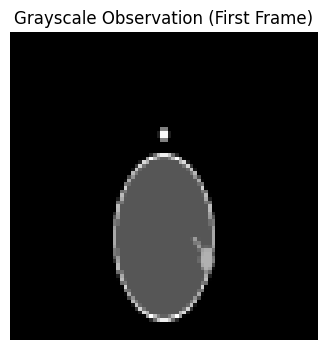

In [21]:
# Example of creating the environment with grayscale images
env = BalancingBallEnv(
    render_mode="rgb_array",
    difficulty="medium",
    fps=30,
    obs_type="game_screen",
    image_size=(84, 84)  # Standard size for many RL frameworks
)

# Reset environment to get initial observation
obs, info = env.reset()

# Print observation shape to verify
print(f"Observation shape: {obs.shape}")  # Should be (84, 84, 3) for grayscale with 3 stacked frames

# Display a sample observation (first frame only)
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.imshow(obs[:,:,0], cmap='gray')
plt.title("Grayscale Observation (First Frame)")
plt.axis('off')
plt.show()